In [2]:
from __future__ import absolute_import, division, print_function

import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.8.0
Eager execution: True


In [3]:
train_dataset_url = "http://download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /Users/keisuke/.keras/datasets/iris_training.csv


In [8]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [9]:
def parse_csv(line):
  example_defaults = [[0.], [0.], [0.], [0.], [0]]  # sets field types
  parsed_line = tf.decode_csv(line, example_defaults)
  # First 4 fields are features, combine into single tensor
  features = tf.reshape(parsed_line[:-1], shape=(4,))
  # Last field is the label
  label = tf.reshape(parsed_line[-1], shape=())
  return features, label

In [10]:
train_dataset = tf.data.TextLineDataset(train_dataset_fp)
print(train_dataset)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
train_dataset = train_dataset.shuffle(buffer_size=1000)  # randomize
train_dataset = train_dataset.batch(32)

# View a single example entry from a batch
features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

<TextLineDataset shapes: (), types: tf.string>
example features: tf.Tensor([6.1 2.9 4.7 1.4], shape=(4,), dtype=float32)
example label: tf.Tensor(1, shape=(), dtype=int32)


In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(3)
])

In [7]:
def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

In [8]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

In [16]:
## Note: Rerunning this cell uses the same model variables

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tfe.metrics.Mean()
  epoch_accuracy = tfe.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.variables),
                              global_step=tf.train.get_or_create_global_step())

    # Track progress
    epoch_loss_avg(loss(model, x, y))  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())
  
  if epoch % 20 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.143, Accuracy: 98.333%
Epoch 020: Loss: 0.133, Accuracy: 97.500%
Epoch 040: Loss: 0.109, Accuracy: 97.500%
Epoch 060: Loss: 0.104, Accuracy: 98.333%
Epoch 080: Loss: 0.093, Accuracy: 97.500%
Epoch 100: Loss: 0.088, Accuracy: 99.167%
Epoch 120: Loss: 0.087, Accuracy: 97.500%
Epoch 140: Loss: 0.081, Accuracy: 99.167%
Epoch 160: Loss: 0.085, Accuracy: 99.167%
Epoch 180: Loss: 0.075, Accuracy: 97.500%
Epoch 200: Loss: 0.071, Accuracy: 99.167%


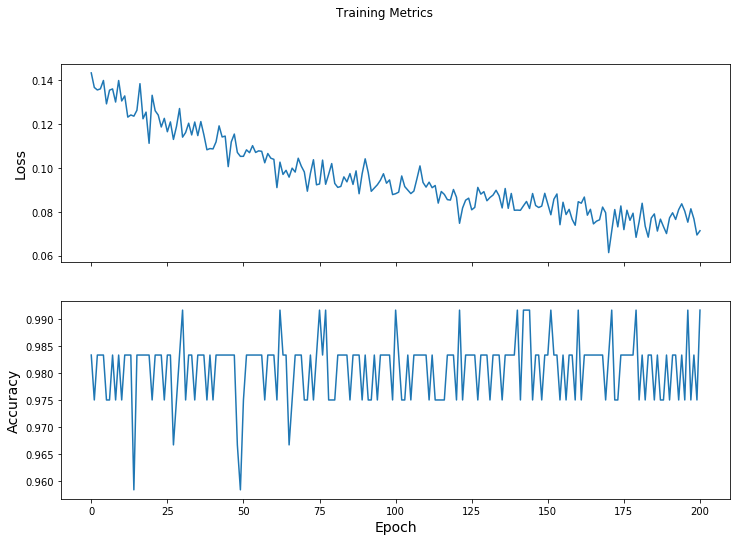

In [17]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)

plt.show()

In [11]:
test_url = "http://download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

test_dataset = tf.data.TextLineDataset(test_fp)
test_dataset = test_dataset.skip(1)             # skip header row
test_dataset = test_dataset.map(parse_csv)      # parse each row with the funcition created earlier
test_dataset = test_dataset.shuffle(1000)       # randomize
test_dataset = test_dataset.batch(32)           # use the same batch size as the training set

16384/573 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [19]:
test_accuracy = tfe.metrics.Accuracy()

for (x, y) in test_dataset:
  test_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 96.667%


In [20]:
class_ids = ["Iris setosa", "Iris versicolor", "Iris virginica"]

predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  name = class_ids[class_idx]
  print("Example {} prediction: {}".format(i, name))

Example 0 prediction: Iris setosa
Example 1 prediction: Iris versicolor
Example 2 prediction: Iris virginica


In [2]:
import matplotlib.pyplot as plt

In [3]:
a = [1,2,3,4]

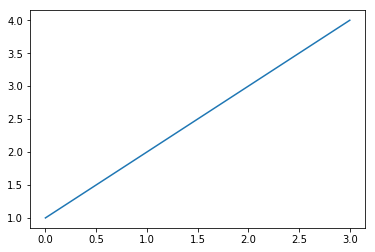

In [4]:
plt.plot(a)

In [6]:
plt.show()